<a href="https://colab.research.google.com/github/Kirk-KD/asd-eye-tracking/blob/master/asd_eye_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

from sklearn import metrics, svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb

In [2]:
DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/ASD Eye Tracking/data'
METADATA_CSV = os.path.join(DATA_ROOT, 'Metadata_Participants.csv')
EYE_TRACKING_OUTPUT_DIR = os.path.join(DATA_ROOT, 'Eye-tracking Output')

# Load metadata

In [3]:
metadata_df = pd.read_csv(METADATA_CSV)
metadata_df = metadata_df.rename(columns={'ParticipantID': 'participant'})
metadata_df['Class'] = metadata_df['Class'].map({'ASD': 1, 'TD': 0})
metadata_df.head()

,participant,Gender,Age,Class,CARS Score
0,1,M,7.0,1,32.5
1,2,F,8.9,1,36.5
2,3,M,4.4,1,27.0
3,4,M,6.9,1,35.0
4,5,M,8.9,1,31.0


# Load and join experiments

In [4]:
columns_to_load = [
    'RecordingTime [ms]',  # timestamp
    'Trial',
    'Stimulus',
    'Participant',  # ID
    'Category Group',  # 'Eye' or 'Information'
    'Category Right',  # 'Fixation', 'Saccade', 'Blink', or 'Separator'
    'Category Left',
    'AOI Name Right',  # 'corps' (french for body) and others
    'AOI Name Left',
    'Pupil Diameter Right [mm]',
    'Pupil Diameter Left [mm]'
]

experiments = []
for i in range(1, 26):
    experiment = pd.read_csv(
        os.path.join(EYE_TRACKING_OUTPUT_DIR, f'{i}.csv'),
        dtype=defaultdict(lambda: str),
        na_values=['-'],
        index_col=0,
        low_memory=False
    )
    for col in columns_to_load:
        if col not in experiment.columns:
            experiment[col] = pd.NA
    experiment = experiment[columns_to_load]
    experiments.append(experiment)

experiments_df = pd.concat(experiments, ignore_index=True)

experiments_df['look_category'] = experiments_df['Category Right'].combine_first(experiments_df['Category Left'])
experiments_df['pupil_diameter_mm'] = experiments_df['Pupil Diameter Right [mm]'].combine_first(experiments_df['Pupil Diameter Left [mm]'])
experiments_df.drop(columns=['Category Right', 'Category Left', 'Pupil Diameter Right [mm]', 'Pupil Diameter Left [mm]'], inplace=True)

numerics = ['Participant', 'RecordingTime [ms]', 'pupil_diameter_mm']
for col in numerics:
    experiments_df[col] = pd.to_numeric(experiments_df[col], errors='coerce')

experiments_df.dropna(subset=['Participant', 'Stimulus', 'Trial'])
experiments_df.head()

,RecordingTime [ms],Trial,Stimulus,Participant,Category Group,AOI Name Right,AOI Name Left,look_category,pupil_diameter_mm
0,4780015.315,Trial020,20 eye tracking (ballon droite).avi,50.0,Information,NaN,NaN,Separator,NaN
1,4780020.865,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.3785
2,4780040.758,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.4050
3,4780080.503,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.4273
4,4780120.360,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.3514


What percent of each column is NA?

40% of participants are NA, this is because many rows have participants "Unidentified(Pos)" and "Unidentified(Neg)". The author of the dataset did not clarify the intended purpose and cause of these values, so for training, these rows will be dropped.

In [5]:
experiments_df.isna().mean().round(3)

,0
RecordingTime [ms],0.000
Trial,0.000
Stimulus,0.000
Participant,0.400
Category Group,0.000
AOI Name Right,0.682
AOI Name Left,0.684
look_category,0.048
pupil_diameter_mm,0.373


# Separate into groups

Group experiments by looking for the rows where 'Category Group' is 'Information'

In [6]:
experiments_df['Participant'] = experiments_df['Participant'].astype(int, errors='ignore')
experiments_df.dropna(subset=['Participant'], inplace=True)

experiments_df['SessionID'] = (experiments_df['Category Group'] == 'Information').cumsum()
grouped_experiments = experiments_df[experiments_df['Category Group'] == 'Eye'].groupby('SessionID')

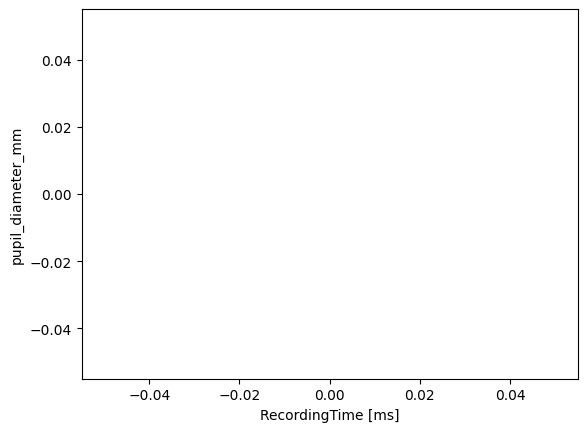

,RecordingTime [ms],Trial,Stimulus,Participant,Category Group,AOI Name Right,AOI Name Left,look_category,pupil_diameter_mm,SessionID
1420704,3101079.075,Trial008,8 voc chien G.jpg,37.0,Eye,NaN,NaN,Saccade,NaN,1547
1420705,3101098.960,Trial008,8 voc chien G.jpg,37.0,Eye,NaN,NaN,Saccade,NaN,1547
1420706,3101118.850,Trial008,8 voc chien G.jpg,37.0,Eye,NaN,NaN,Saccade,NaN,1547
1420707,3101138.841,Trial008,8 voc chien G.jpg,37.0,Eye,NaN,NaN,Saccade,NaN,1547
1420708,3101158.708,Trial008,8 voc chien G.jpg,37.0,Eye,NaN,NaN,Saccade,NaN,1547


In [7]:
import random

keys = list(grouped_experiments.groups.keys())
key = random.choice(keys)
sample = grouped_experiments.get_group(key)

sns.lineplot(
    data=sample,
    x='RecordingTime [ms]',
    y='pupil_diameter_mm',
    marker='o'
)
plt.show()

sample.head()

Verify the ~20ms interval of RecordingTime.

In [8]:
intervals = grouped_experiments['RecordingTime [ms]'].diff().dropna().reset_index()
intervals['RecordingTime [ms]'].median()

19.86700000008568

# Contruct aggregated dataset

In [10]:
def summarize_group(g):
    df = g.copy()

    df = df[~(df['Category Group'] == 'Information')]
    df['event'] = df['look_category']
    df['is_new_event'] = (df['event'] != df['event'].shift()).astype(int)
    df['event_id'] = df['is_new_event'].cumsum()
    events = (
        df.groupby(['event_id', 'event'])
        .size()
        .reset_index(name='n_rows')
    )
    events['event_duration_ms'] = events['n_rows'] * 20

    row = pd.Series({
        'participant': int(g['Participant'].unique()[0]),
        'stimulus': g['Stimulus'].unique()[0],
        'trial': g['Trial'].unique()[0]
    })

    # Saccade duration mean and frequency (Hz)
    saccade_events = events[events['event'] == 'Saccade']
    row['saccade_mean'] = saccade_events['event_duration_ms'].mean()
    row['saccade_count'] = len(saccade_events)
    row['saccade_freq_hz'] = row['saccade_count'] / len(g) / 0.02

    # Fixation duration mean and frequency (Hz)
    fixation_events = events[events['event'] == 'Fixation']
    row['fixation_mean'] = fixation_events['event_duration_ms'].mean()
    row['fixation_count'] = len(fixation_events)
    row['fixation_freq_hz'] = row['fixation_count'] / len(g)

    # Pupil diameter mean, range (mm)
    pupil_diameter = df['pupil_diameter_mm']
    ## Too extreme values
    df.loc[(pupil_diameter < 2) | (pupil_diameter > 8), 'pupil_diameter_mm'] = pd.NA
    ## Flat areas in pupil diameter graph signals faulty data
    flat_mask = pupil_diameter.diff().abs() < 0.01
    consec_flat = (flat_mask != flat_mask.shift()).cumsum()
    flat_len = flat_mask.groupby(consec_flat).transform('sum')
    pupil_diameter.loc[flat_mask & (flat_len > 3)] = pd.NA
    ## Too many NaNs (>=20%)
    pupil_pct_na = pupil_diameter.isna().mean()
    if pupil_pct_na < 0.2:
        row['pupil_diameter_mean'] = pupil_diameter.mean()
        row['pupil_diameter_range'] = pupil_diameter.max() - pupil_diameter.min()
    else:
        row['pupil_diameter_mean'] = pd.NA
        row['pupil_diameter_range'] = pd.NA

    return row

# initial construction
dataset = (
    grouped_experiments
    .apply(summarize_group)
    .dropna()
    .reset_index(drop=True)
    .merge(metadata_df, on='participant', how='left')
)

FEATURES = [
    'saccade_mean',
    'saccade_freq_hz',
    'fixation_mean',
    'fixation_freq_hz',
    'pupil_diameter_mean',
    'pupil_diameter_range'
]

# apply z-score for features for each group of stimulus to normalize
dataset[FEATURES] = dataset.groupby('stimulus')[FEATURES].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)

dataset.head()


/tmp/ipython-input-2785080764.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)
/tmp/ipython-input-2785080764.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[FEATURES] = dataset.groupby('stimulus')[FEATURES].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)


,participant,stimulus,trial,saccade_mean,saccade_count,saccade_freq_hz,fixation_mean,fixation_count,fixation_freq_hz,pupil_diameter_mean,pupil_diameter_range,Gender,Age,Class,CARS Score
0,50,20 eye tracking (ballon droite).avi,Trial020,0.432349,140,0.675339,-0.422791,139,0.628373,0.601463,1.567044,F,11.5,0,NaN
1,52,20 eye tracking (ballon droite).avi,Trial020,1.698679,140,0.015105,-0.240712,139,-0.276474,-1.185244,-1.253619,M,10.7,0,NaN
2,49,20 eye tracking (ballon droite).avi,Trial020,-0.570874,122,0.513078,-0.568519,126,0.746900,0.519646,-0.520876,F,12.3,0,NaN
3,55,20 eye tracking (ballon droite).avi,Trial020,0.069748,58,-1.722935,-0.527453,75,-1.021760,-0.004086,0.425162,F,6.5,0,NaN
4,53,20 eye tracking (ballon droite).avi,Trial020,0.618595,116,-0.613316,1.745061,115,-1.148041,-0.973194,-0.830692,M,6.8,0,NaN


Class distribution (0 = TD, 1 = ASD)

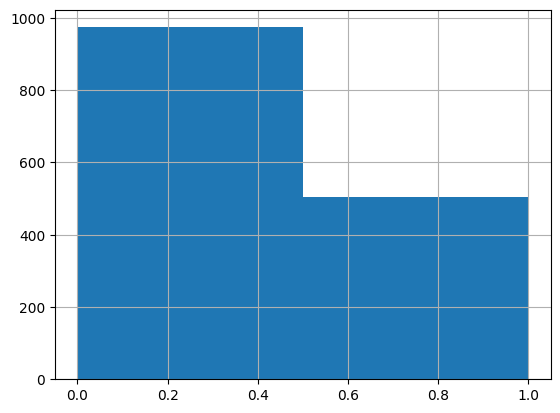

In [11]:
dataset['Class'].hist(bins=2)
plt.show()

# Correlations

In [12]:
# r: how strongly the feature correlates with Class
# p: lower means the feature is statistically more significant

rows = []
for c in FEATURES:
    res = pointbiserialr(dataset['Class'], dataset[c])
    rows.append({
        'Feature': c,
        'r': round(res.correlation, 4),
        'p': round(res.pvalue, 4)
    })

df_corr = pd.DataFrame(rows)
df_corr = df_corr.sort_values(['r', 'p'], ascending=False).reset_index(drop=True)
df_corr

,Feature,r,p
0,pupil_diameter_range,0.3499,0.0000
1,pupil_diameter_mean,0.3300,0.0000
2,saccade_mean,0.2212,0.0000
3,saccade_freq_hz,0.0950,0.0003
4,fixation_freq_hz,0.0365,0.1605
5,fixation_mean,-0.2524,0.0000


# Train

In [13]:
SEED = 7

class Trainer:
    def __init__(self, X, y, groups, model_class, balanced=False, n_splits=5):
        self.X = X
        self.y = y
        self.groups = groups
        self.model_class = model_class
        self.balanced = balanced
        self.n_splits = n_splits
        self.model = None

    def fit(self):
        gkf = GroupKFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        results_list = []

        for train_idx, test_idx in gkf.split(self.X, self.y, groups=self.groups):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]

            model_kwargs = {'random_state': SEED} if 'random_state' in self.model_class().get_params() else {}
            if self.balanced and hasattr(self.model_class, 'class_weight'):
                model_kwargs['class_weight'] = 'balanced'

            self.model = self.model_class(**model_kwargs)

            if self.balanced and hasattr(self.model, 'fit'):
                sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
                self.model.fit(X_train, y_train, sample_weight=sample_weights)
            else:
                self.model.fit(X_train, y_train)

            y_pred = self.model.predict(X_test)

            results = {
                'balanced_accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
                'kappa': metrics.cohen_kappa_score(y_test, y_pred),
                'precision': metrics.precision_score(y_test, y_pred),
                'sensitivity': metrics.recall_score(y_test, y_pred),
                'specificity': metrics.recall_score(y_test, y_pred, pos_label=0),
                'f1': metrics.f1_score(y_test, y_pred)
            }
            results_list.append(results)

        avg_results = {k: np.mean([r[k] for r in results_list]) for k in results_list[0]}
        return avg_results


In [14]:
model_configs = [
    ('DecisionTree', DecisionTreeClassifier, False),
    ('DecisionTree_Balanced', DecisionTreeClassifier, True),
    ('SVM', svm.SVC, False),
    ('SVM_Balanced', svm.SVC, True),
    ('KNN', KNeighborsClassifier, False),
    ('XGBoost', xgb.XGBClassifier, False),
    ('XGBoost_Balanced', xgb.XGBClassifier, True),
    ('AdaBoost', AdaBoostClassifier, False),
    ('AdaBoost_Balanced', AdaBoostClassifier, True)
]

results_list = []

for name, model_class, balanced in model_configs:
    trainer = Trainer(
        X=dataset[FEATURES],
        y=dataset['Class'],
        groups=dataset['participant'],
        model_class=model_class,
        balanced=balanced
    )
    metrics_results = trainer.fit()
    results_list.append({'Name': name, **metrics_results})

df_cv_results = pd.DataFrame(results_list).sort_values('kappa', ascending=False)
df_cv_results


,Name,balanced_accuracy,kappa,precision,sensitivity,specificity,f1
5,XGBoost,0.703557,0.408581,0.627344,0.589907,0.817206,0.599418
8,AdaBoost_Balanced,0.707920,0.392686,0.563451,0.710856,0.704985,0.619104
6,XGBoost_Balanced,0.700112,0.391815,0.594554,0.629375,0.770850,0.600606
7,AdaBoost,0.692541,0.382373,0.609239,0.592096,0.792986,0.587011
2,SVM,0.680822,0.371729,0.630431,0.525992,0.835652,0.559272
1,DecisionTree_Balanced,0.675157,0.344608,0.559923,0.596842,0.753471,0.572512
3,SVM_Balanced,0.681006,0.339017,0.525467,0.711463,0.650548,0.592324
4,KNN,0.653111,0.308359,0.558547,0.519772,0.786449,0.529668
0,DecisionTree,0.632182,0.256778,0.501402,0.549895,0.714469,0.518534
